# Create a resnet model for CIFAR-10

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
import time
from os import listdir
from os.path import isfile, join
import random

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 20)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image


# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

data_path = '/home/ubuntu/data/training/image/cifar10/'

print('Tensorflow version: ', tf.__version__)


Tensorflow version:  1.2.1


In [2]:
with open(data_path+'labels.txt') as f:
    categories = f.read().splitlines()
print(categories)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


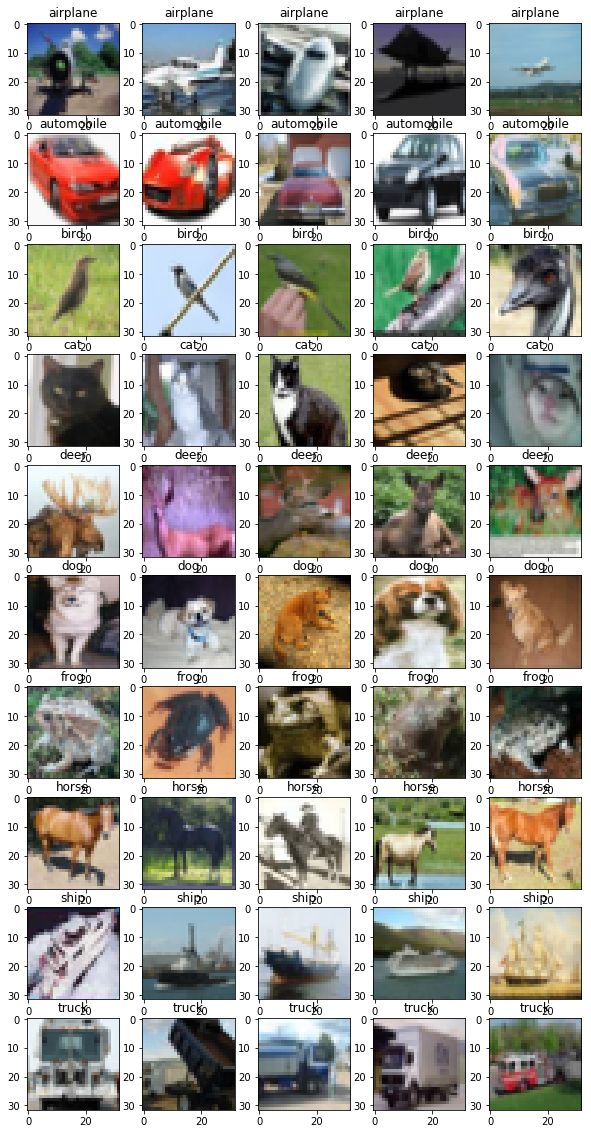

In [3]:
# Examine the data
fig = plt.figure()
n=0
for i, category in enumerate(categories):
    filelist = [f for f in listdir(join(data_path, 'train', category)) if isfile(join(data_path, 'train', category, f))]
    random.shuffle(filelist) # Randomize images
    for f in filelist[:5]: 
        n += 1
        a = fig.add_subplot(10,5,n)
        a.set_title(category)
        img = plt.imread(join(data_path, 'train', category, f))
        plt.imshow(img)
    

    

In [4]:
from tensorflow.contrib.keras import models, layers, optimizers, callbacks, preprocessing, regularizers


In [5]:
# Based on https://gist.github.com/JefferyRPrice/c1ecc3d67068c8d9b3120475baba1d7e

def residual_layer(input_tensor, nb_in_filters=64, nb_bottleneck_filters=16, filter_sz=3, stage=0, reg=0.0):

    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    if stage>1: # first activation is just after conv1
        x = layers.BatchNormalization(axis=-1, name='bn'+ str(stage)+'a')(input_tensor)
        x = layers.Activation('relu', name='relu'+str(stage)+'a')(x)
    else:
        x = input_tensor

    x = layers.Conv2D(nb_bottleneck_filters, (1, 1),
                      kernel_initializer='glorot_normal',
                      kernel_regularizer=regularizers.l2(reg),
                      use_bias=False,
                      name='conv'+str(stage)+'a')(x)

    # batchnorm-relu-conv, from nb_bottleneck_filters to nb_bottleneck_filters via FxF conv
    x = layers.BatchNormalization(axis=-1, name='bn'+ str(stage)+'b')(x)
    x = layers.Activation('relu', name='relu'+str(stage)+'b')(x)
    x = layers.Conv2D(nb_bottleneck_filters, (filter_sz, filter_sz),
                      padding='same',
                      kernel_initializer='glorot_normal',
                      kernel_regularizer=regularizers.l2(reg),
                      use_bias = False,
                      name='conv'+str(stage)+'b')(x)

    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    x = layers.BatchNormalization(axis=-1, name='bn'+ str(stage)+'c')(x)
    x = layers.Activation('relu', name='relu'+str(stage)+'c')(x)
    x = layers.Conv2D(nb_in_filters, (1, 1),
                      kernel_initializer='glorot_normal',
                      kernel_regularizer=regularizers.l2(reg),
                      name='conv'+str(stage)+'c')(x)

    # merge
    x = layers.add([x, input_tensor], name='add'+str(stage))

    return x

In [6]:
# Minimal example
sz_ly0_filters, nb_ly0_filters, nb_ly0_stride = (64,5,2)
sz_res_filters, nb_res_filters, nb_res_stages = (3,16,3)

# Complete example: 92% of accuracy
#sz_ly0_filters, nb_ly0_filters, nb_ly0_stride = (128,3,2)
#sz_res_filters, nb_res_filters, nb_res_stages = (3,32,25)


  
    
img_input = layers.Input(shape=(32,32,3), name='cifar')

# Initial conv layer
x = layers.Conv2D(sz_ly0_filters, (nb_ly0_filters,nb_ly0_filters),
                  strides=(nb_ly0_stride, nb_ly0_stride), padding='same', 
                  kernel_initializer='glorot_normal',
                  kernel_regularizer=regularizers.l2(1.e-4),
                  use_bias=False, name='conv0')(img_input)

x = layers.BatchNormalization(axis=-1, name='bn0')(x)
x = layers.Activation('relu', name='relu0')(x)
x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same", name='maxp0')(x)

# Resnet layers
for stage in range(1, nb_res_stages+1):
    x = residual_layer(x, nb_in_filters=64, nb_bottleneck_filters=nb_res_filters,
                       filter_sz=sz_res_filters, stage=stage,reg=0.0)

# Complete last resnet layer    
x = layers.BatchNormalization(axis=-1, name='bnF')(x)
x = layers.Activation('relu', name='reluF')(x)


# Final layer
x = layers.AveragePooling2D((8, 8), name='avg_pool')(x)
x = layers.Flatten(name='flat')(x)
x = layers.Dense(10, activation='softmax', name='fc1')(x)

model1 = models.Model(inputs=img_input, outputs=x)
model1.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cifar (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 16, 16, 64)        4800      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
relu0 (Activation)           (None, 16, 16, 64)        0         
_________________________________________________________________
maxp0 (MaxPooling2D)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv1a (Conv2D)              (None, 8, 8, 16)          1024      
_________________________________________________________________
bn1b (BatchNormalization)    (None, 8, 8, 16)          64        
__________

In [5]:
# Extract images from directories

my_datagen = preprocessing.image.ImageDataGenerator()

train_generator = my_datagen.flow_from_directory(
    join(data_path, 'train'),
    target_size=(32, 32),
    batch_size=50000)


test_generator = my_datagen.flow_from_directory(
    join(data_path, 'test'),
    target_size=(32, 32),
    batch_size=10000)

X_train, y_train = next(train_generator)
X_test,  y_test  = next(test_generator)


Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [6]:
# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [9]:
batch_size = 32

# Select optimizer and compile model
opt = optimizers.Adam(lr=1E-3)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# Train
epochs = 30

tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/cifar10/resnet1')
history1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test), callbacks=[tb_callback_ln])


Train on 50000 samples, validate on 10000 samples
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'float' object has no attribute 'name'
Epoch 1/30
50000/50000 [==============================] - 36s - loss: 1.4830 - acc: 0.4616 - val_loss: 1.2642 - val_acc: 0.5430
Epoch 2/30
50000/50000 [==============================] - 35s - loss: 1.2061 - acc: 0.5669 - val_loss: 1.2113 - val_acc: 0.5731
Epoch 3/30
50000/50000 [==============================] - 35s - loss: 1.0882 - acc: 0.6116 - val_loss: 1.0373 - val_acc: 0.6243
Epoch 4/30
50000/50000 [==============================] - 35s - loss: 1.0117 - acc: 0.6399 - val_loss: 1.1386 - val_acc: 0.5958
Epoch 5/30
50000/50000 [==============================] - 39s - loss: 0.9573 - acc: 0.6603 - val_loss: 1.0046 - val_acc: 0.6457
Epoch 6/30
50000/50000 [==============================] - 39s - loss: 0.9100 - acc: 0.6794 - val_loss: 0.9220 - val_acc: 0.6712
Epoch 7/30
50000/50000 [==============================]

In [10]:
# Select optimizer and compile model
opt = optimizers.Adam(lr=1E-4)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# Train
epochs = 10
history2 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test), callbacks=[tb_callback_ln])


Train on 50000 samples, validate on 10000 samples
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'float' object has no attribute 'name'
Epoch 1/10
50000/50000 [==============================] - 35s - loss: 0.5288 - acc: 0.8225 - val_loss: 0.6819 - val_acc: 0.7727
Epoch 2/10
50000/50000 [==============================] - 35s - loss: 0.5135 - acc: 0.8277 - val_loss: 0.6831 - val_acc: 0.7719
Epoch 3/10
50000/50000 [==============================] - 35s - loss: 0.5101 - acc: 0.8261 - val_loss: 0.6854 - val_acc: 0.7746
Epoch 4/10
50000/50000 [==============================] - 36s - loss: 0.5044 - acc: 0.8296 - val_loss: 0.6866 - val_acc: 0.7728
Epoch 5/10
50000/50000 [==============================] - 35s - loss: 0.5032 - acc: 0.8295 - val_loss: 0.6892 - val_acc: 0.7707
Epoch 6/10
50000/50000 [==============================] - 36s - loss: 0.5027 - acc: 0.8284 - val_loss: 0.6922 - val_acc: 0.7714
Epoch 7/10
50000/50000 [==============================]

In [11]:
# Select optimizer and compile model
opt = optimizers.Adam(lr=1E-5)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# Train
epochs = 10
history3 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test), callbacks=[tb_callback_ln])


Train on 50000 samples, validate on 10000 samples
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'float' object has no attribute 'name'
Epoch 1/10
50000/50000 [==============================] - 36s - loss: 0.4873 - acc: 0.8347 - val_loss: 0.6885 - val_acc: 0.7713
Epoch 2/10
50000/50000 [==============================] - 35s - loss: 0.4839 - acc: 0.8350 - val_loss: 0.6882 - val_acc: 0.7733
Epoch 3/10
50000/50000 [==============================] - 35s - loss: 0.4827 - acc: 0.8369 - val_loss: 0.6882 - val_acc: 0.7733
Epoch 4/10
50000/50000 [==============================] - 35s - loss: 0.4824 - acc: 0.8374 - val_loss: 0.6891 - val_acc: 0.7736
Epoch 5/10
50000/50000 [==============================] - 36s - loss: 0.4819 - acc: 0.8374 - val_loss: 0.6893 - val_acc: 0.7733
Epoch 6/10
50000/50000 [==============================] - 35s - loss: 0.4820 - acc: 0.8373 - val_loss: 0.6895 - val_acc: 0.7736
Epoch 7/10
50000/50000 [==============================]

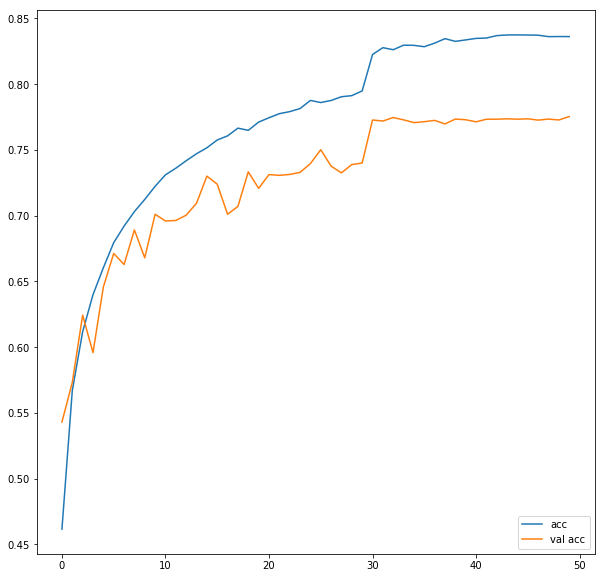

In [13]:
# Plot accuracy
plt.rcParams['figure.figsize'] = (10, 10)        # size of images

plt.plot(history1.history['acc'] + history2.history['acc'] + history3.history['acc'], label='acc')
plt.plot(history1.history['val_acc'] + history2.history['val_acc'] + history3.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

In [16]:
# Save model
model1.save('/tmp/cifar10_resnet1.h5')


In [17]:
# Load and test model
y_pred = model1.predict(X_test)
print(y_pred.shape)


(10000, 10)


In [22]:
# Score and select prediction with max prob
pred_test = np.argmax(y_pred, axis=1)
y_test_real = np.argmax(y_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_real, pred_test))

[[811  20  37  12   9   7  10  12  46  36]
 [ 16 865   7   6   1   3   6   4  20  72]
 [ 50   4 672  46  79  50  49  39   6   5]
 [ 24   6  53 587  66 153  47  36  16  12]
 [ 26   1  50  47 749  32  39  50   5   1]
 [  7   4  41 162  25 686  16  46   5   8]
 [  6   5  31  53  34  17 839   7   4   4]
 [ 13   1  23  33  43  63   3 806   2  13]
 [ 63  16  11   7   2   3   3   3 872  20]
 [ 27  68   3   7   4   1   1   8  15 866]]


# Evaluate the same model with 25 resnet layers
    - Add features of the model and the training process

In [3]:
from tensorflow.contrib.keras import models,  preprocessing

# Create generator of the test data with the correct transformation
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    join(data_path, 'test'),
    target_size=(32, 32),
    batch_size=32)

# Load model
model_25 = models.load_model('cifar10_resnet_optimal.h5')

Found 10000 images belonging to 10 classes.


In [5]:
y_pred = model_25.predict_generator(test_generator, len(test_generator.filenames))
print(len(y_pred))

319504


In [8]:
test_generator.batch_index

0

In [7]:
#gen = image.ImageDataGenerator(shuffle=False, ...).flow_from_directory(...)
#y_pred = model_25.predict_generator(test_generator, len(test_generator.filenames))
                                
X_test = []
y_test = []
batch_index = 0

while batch_index <= test_generator.batch_index:
    x_b, y_b = test_generator.next()
    X_test.append(x_b)
    y_test.append(y_b)
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print(X_test.shape)
print(y_test.shape)

(6,)
(6,)


In [17]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix

pred_test = np.argmax(y_pred, axis=1)
real_test = np.argmax(y_test, axis=1)
print(confusion_matrix(real_test[:9968], pred_test[:9968]))

[[ 69  53 129 126   0 151  64 125 111 171]
 [ 63  59 127 105   0 185  60 127 125 148]
 [ 72  65 124 111   0 149  65 132 138 144]
 [ 69  64 117 120   0 173  65 113 117 158]
 [ 68  75 126 126   0 145  62 110 136 151]
 [ 62  69 126 129   0 141  65 116 120 165]
 [ 54  59 137 144   0 148  58 128 126 145]
 [ 54  61 109 138   0 179  55 132 109 158]
 [ 60  52 133 119   0 148  66 144 128 146]
 [ 51  66 118 129   0 136  64 120 135 173]]


In [ ]:
# Example of errors

#Print probabilities to the first erros
test_errors=[]
test_errors_real=[]
test_errors_predict=[]
num_errors = 32
n = 0
for i in range(len(pred_test)):
    if pred_test[i] != real_test[i] and n < num_errors: #Error!
        n += 1
        test_errors += [X_test[i,:,:]]
        test_errors_real += [real_test[i]]
        test_errors_predict += [pred_test[i]]
        
        #Print first propabilities
        index = y_pred[i].argsort()[::-1]
        print('n: %2i - Pred 1: %1i(%0.3f) - Pred 2: %1i(%0.3f)' % (n,
              index[0], y_pred[i][index[0]], index[1], y_pred[i][index[1]]))
        
print("Num errors: ", len(test_errors))


#Plot 32 images wrong classified.
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4, 8, n+1)
    a.set_title('R:'+str(test_errors_real[i])+' - P:'+str(test_errors_predict[i]))
    fig.tight_layout()
    plt.imshow(test_errors[i])

